In [1]:

import uproot
import numpy as np
import vector
import math
from tqdm import tqdm
from ipywidgets import interact, FloatSlider

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib widget


e_mass = 511
E_i = 511
r_e = 2.817e-15


def process_root_file(file_location):
    """
    Processes a ROOT file, decodes the 'processName' branch, and returns the data object.

    Args:
        file_location (str): Path to the ROOT file.

    Returns:
        dict: A dictionary containing the processed data.
    """
    # Open the ROOT file and access the tree
    file = uproot.open(file_location)
    tree = file["Hits"]

    # Load the data into a dictionary
    data = tree.arrays(library="np")

    meta = {} 
    if 'Metadata' in file:
        metatree = file['Metadata']
        meta_array = metatree.arrays(library='np')
        meta = {k: v[0] if v.size==1 else v for k, v in meta_array.items()}
    else:
        print("⚠️No Metadata found!")

    # Print the number of rows
    print(f"Number of rows in the data: {len(data['processName'])}")

    return meta, data

def klein_nishina(theta_degrees, E_i):
    # Convert degrees to radians for computation
    theta_radians = np.radians(theta_degrees)
    
    # Compute scattered photon energy
    E_prime = E_i / (1 + (E_i / e_mass) * (1 - np.cos(theta_radians)))
    
    # Compute differential cross-section
    differential_cross_section = 0.5 * r_e**2 * (E_prime / E_i)**2 * (
        (E_prime / E_i) + (E_i / E_prime) - np.sin(theta_radians)**2
    )
    
    return differential_cross_section

def dr1_i(r1, r2, delta, component='x'):
    if component not in ['x', 'y', 'z']:
        raise ValueError("Component must be 'x', 'y', or 'z'.")

    r1_comp = getattr(r1, component)
    delta_comp = getattr(delta, component)

    #factor = ((r1.mag2 * r2.mag2 - (r1.dot(r2))**2 + 1e-8  )**(-0.5))
    
    #print(f"factor: {factor}")
    # NUM = delta_comp * r1.mag2 * delta.dot(r2) - r1_comp * delta.mag2 * r1.dot(r2)
    # DEN = np.sin(delta.theta) * (delta.mag**3) * (r1.mag**3)

    NUM = -r1_comp * r1.dot(delta) * delta.mag2 + (delta_comp - r1_comp) * delta.mag2 * r1.mag2  + delta_comp * r1.dot(delta) * r1.mag2 
    DEN = np.sin(delta.theta) * (delta.mag**3) * (r1.mag**3)

    return   NUM/DEN

def dr2_i(r1,r2,delta,component= 'x'):
    if component not in ['x', 'y', 'z']:
        raise ValueError("Component must be 'x', 'y', or 'z'.")

    r1_comp = getattr(r1, component)
    r2_comp = getattr(r2, component)

    NUM = r1_comp * delta.mag2 - (r2_comp-r1_comp) * r1.dot(delta) 
    DEN = np.sin(delta.theta) * (delta.mag**3) * (r1.mag)
    
    return NUM/DEN

def sigma_theta(r1,r2,delta, sigma_par, sigma_perp):
    
    d_sigma = (
        sigma_par**2  * dr1_i(r1, r2, delta, 'x')**2 +
        sigma_par**2  * dr1_i(r1, r2, delta, 'y')**2 +
        sigma_perp**2 * dr1_i(r1, r2, delta, 'z')**2 +

        sigma_par**2  * dr2_i(r1, r2, delta, 'x')**2 +
        sigma_par**2  * dr2_i(r1, r2, delta, 'y')**2 +
        sigma_perp**2 * dr2_i(r1, r2, delta, 'z')**2  
    )
    
    return np.degrees(d_sigma**0.5)


def d_delE(delE):
    alfa = E_i/511

    NUM = E_i
    DEN = (E_i - delE)*delE*np.sqrt(2*E_i*alfa/delE - 2*alfa - 1)

    return NUM/DEN

def sigma_beta(delE,sigma_E):
    return np.degrees(np.abs(d_delE(delE)) * sigma_E)

def sigma_D(r1,r2,delta,delE, 
            Theta,Beta,
            sigma_par,sigma_perp,sigma_E):

    sigma_theta_val = sigma_theta(r1,r2,delta,sigma_par,sigma_perp)
    sigma_beta_val = sigma_beta(delE,sigma_E)
    
    return r1.mag * np.abs(np.cos(np.radians(Theta - Beta) )) * np.radians( np.sqrt(sigma_theta_val**2 + sigma_beta_val**2))

### Load the data from root files

In [2]:
meta, data = process_root_file('root_files/center_511keV_100MBq_FILT.root')

Number of rows in the data: 8791674


In [3]:
meta750, data750 = process_root_file('root_files/center_750keV_100MBq_FILT.root')

Number of rows in the data: 6572326


In [4]:
meta1M, data1M = process_root_file('root_files/center_1MeV_100MBq_FILT.root')

Number of rows in the data: 5052714


In [3]:
meta.keys()

dict_keys(['totFirstCompt', 'n_rawEvents', 'n_filtEvents', 'percentageKept'])

### First analysis

In [5]:
### 511 keV ###
#Global coordinates
r1     = vector.array({"x": data["posX"][::2], "y": data["posY"][::2], "z": data["posZ"][::2]})    #Compton events
r2     = vector.array({"x": data["posX"][1::2], "y": data["posY"][1::2], "z": data["posZ"][1::2]}) #Photoelectric events
delta  = r2-r1

#Local coordinates
delta_loc  = delta.rotateZ(-r1.phi).rotateY(-r1.theta)
r1_loc     = r1.rotateZ(-r1.phi).rotateY(-r1.theta)
r2_loc     = r2.rotateZ(-r1.phi).rotateY(-r1.theta)


# Calculate the energy deposited in the Compton event
edep = data['edep'][::2] * 1000
edep2 = data['edep'][1::2]*1000
C_beta_raw    = (E_i - 2*edep)/(E_i-edep)
C_beta     = np.clip(C_beta_raw, -1, 1)
beta       = np.degrees(np.acos(C_beta))


theta = np.degrees(delta_loc.theta)

# Filter for events with a large angle (same sector already checked)
filt_0 = (edep< 340.66) & (delta_loc.mag> 0.1)

# Maschera per avere True solo ogni 5 elementi
filt_sample = np.zeros_like(filt_0, dtype=bool)
filt_sample[::5] = True
final_mask = filt_0 & filt_sample


In [6]:
### 750 keV ###
#Global coordinates
r1_750     = vector.array({"x": data750["posX"][::2], "y": data750["posY"][::2], "z": data750["posZ"][::2]})    #Compton events
r2_750     = vector.array({"x": data750["posX"][1::2], "y": data750["posY"][1::2], "z": data750["posZ"][1::2]}) #Photoelectric events
delta_750  = r2_750-r1_750

#Local coordinates
delta_loc750  = delta_750.rotateZ(-r1_750.phi).rotateY(-r1_750.theta)
r1_loc750    = r1_750.rotateZ(-r1_750.phi).rotateY(-r1_750.theta)
r2_loc750     = r2_750.rotateZ(-r1_750.phi).rotateY(-r1_750.theta)


# Calculate the energy deposited in the Compton event
edep_750 = data750['edep'][::2] * 1000
edep2_750 = data750['edep'][1::2]*1000
C_beta_raw750    = (E_i - 2*edep_750)/(E_i-edep_750)
C_beta750     = np.clip(C_beta_raw750, -1, 1)
beta750       = np.degrees(np.acos(C_beta750))


theta750 = np.degrees(delta_loc750.theta)

# Filter for events with a large angle (same sector already checked)
filt_0_750 = (edep_750< 340.66) & (delta_loc750.mag> 0.1)

# Maschera per avere True solo ogni 5 elementi
filt_sample750 = np.zeros_like(filt_0_750, dtype=bool)
filt_sample750[::5] = True
final_mask750 = filt_0_750 & filt_sample750


In [7]:
### 1MeV ###
#Global coordinates
r1_1M    = vector.array({"x": data1M["posX"][::2], "y": data1M["posY"][::2], "z": data1M["posZ"][::2]})    #Compton events
r2_1M     = vector.array({"x": data1M["posX"][1::2], "y": data1M["posY"][1::2], "z": data1M["posZ"][1::2]}) #Photoelectric events
delta_1M  = r2_1M-r1_1M

#Local coordinates
delta_loc1M = delta_1M.rotateZ(-r1_1M.phi).rotateY(-r1_1M.theta)
r1_loc1M   = r1_1M.rotateZ(-r1_1M.phi).rotateY(-r1_1M.theta)
r2_loc1M     = r2_1M.rotateZ(-r1_1M.phi).rotateY(-r1_1M.theta)


# Calculate the energy deposited in the Compton event
edep_1M = data1M['edep'][::2] * 1000
edep2_1M = data1M['edep'][1::2]*1000
C_beta_raw1M   = (E_i - 2*edep_1M)/(E_i-edep_1M)
C_beta1M   = np.clip(C_beta_raw1M, -1, 1)
beta1M       = np.degrees(np.acos(C_beta1M))


theta1M = np.degrees(delta_loc1M.theta)

# Filter for events with a large angle (same sector already checked)
filt_0_1M = (edep_1M < 340.66) & (delta_loc1M.mag> 0.1)

# Maschera per avere True solo ogni 5 elementi
filt_sample1M = np.zeros_like(filt_0_1M, dtype=bool)
filt_sample1M[::5] = True
final_mask1M = filt_0_1M & filt_sample1M


### Setting $\sigma_E, \sigma_\perp, \sigma_\parallel$

In [8]:
sigma_E        = 25
sigma_perp     = 1.3
sigma_par      = 0.35      # 1.3/sqrt(12)

### $\sigma_\theta$ and $\sigma_\beta$ dependencies

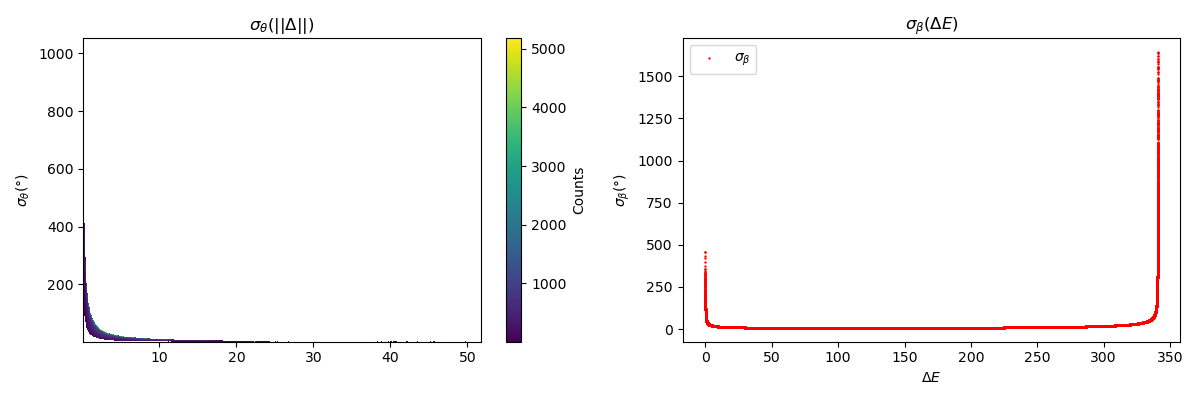

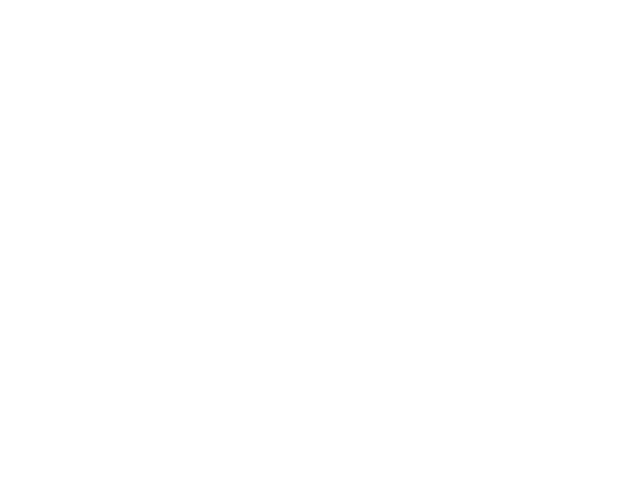

In [9]:
# plot sigma dependecies
sigma_th = sigma_theta(r1_loc[filt_0],r2_loc[filt_0],delta_loc[filt_0],sigma_par,sigma_perp)
sigma_be = sigma_beta(edep[filt_0], sigma_E)

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].scatter(delta_loc.mag[filt_0],sigma_th, s=0.5, alpha = 1, label = r'$\sigma_\theta$')
# axs[0].legend(loc = 'upper right')
# #axs[0].set_yscale('log')
# axs[0].set_xlabel(r'$||\Delta||$')
h = axs[0].hist2d(delta_loc.mag[filt_0],sigma_th, bins=(1000,1000), cmap='viridis', cmin=1)
fig.colorbar(h[3], ax=axs[0], label='Counts')

axs[0].set_ylabel(r'$\sigma_\theta(°)$')
axs[0].set_title(r'$\sigma_\theta(||\Delta||)$')

axs[1].scatter(edep[filt_0],sigma_be, s=0.5,alpha = 1,color = 'red',label = r'$\sigma_\beta$')
axs[1].legend(loc = 'upper left')
#axs[1].set_yscale('log')

axs[1].set_xlabel(r'$\Delta E$')
axs[1].set_ylabel(r'$\sigma_\beta(°)$')
axs[1].set_title(r'$\sigma_\beta(\Delta E)$')
fig.savefig("sigma_dependecies.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Setting thresholds $\lvert \lvert \Delta \rvert \rvert , \Delta E_{min}, \Delta E_{max}$

In [10]:
del_min   = 10
E_min     = 50
E_max     = 270

filt = (delta_loc.mag >del_min)  &  (edep > E_min) & (edep < E_max) & (edep2 > E_min) & filt_0
filt750 = (delta_loc750.mag >del_min)  &  (edep_750 > E_min) & (edep_750 < E_max) & (edep2_750 > E_min) & filt_0_750
filt1M = (delta_loc1M.mag >del_min)  &  (edep_1M > E_min) & (edep_1M < E_max) & (edep2_1M > E_min) & filt_0_1M

In [11]:
sigma_th = sigma_theta(r1_loc[filt],r2_loc[filt],delta_loc[filt],sigma_par,sigma_perp)
sigma_be = sigma_beta(edep[filt], sigma_E)

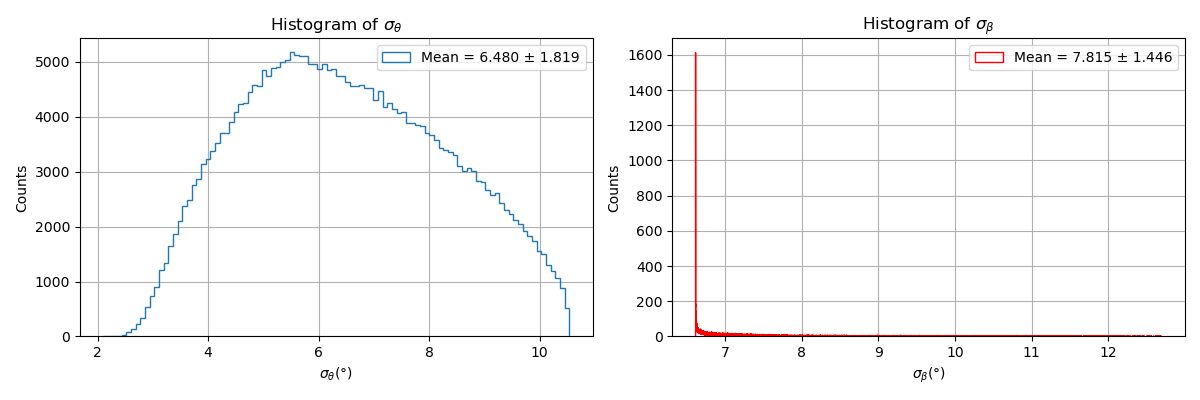

In [12]:
mean_th = np.mean(sigma_th)
std_th = np.std(sigma_th)
mean_be = np.mean(sigma_be)
std_be = np.std(sigma_be)
plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(sigma_th, bins=100, histtype='step', label=fr'Mean = {mean_th:.3f} ± {std_th:.3f}')
axs[0].set_xlabel(r'$\sigma_\theta(°)$')
axs[0].set_ylabel('Counts')
axs[0].legend(loc = 'upper right')
axs[0].grid(True, which='both', axis='both')
axs[0].set_title('Histogram of $\sigma_\\theta$')

axs[1].hist(sigma_be, bins = 100000, edgecolor='red', histtype='step', label=fr'Mean = {mean_be:.3f} ± {std_be:.3f}')
axs[1].set_xlabel(r'$\sigma_\beta(°)$')
axs[1].grid(True, which='both', axis='both')
axs[1].set_ylabel('Counts')
axs[1].legend(loc= 'upper right')
axs[1].set_title('Histogram of $\sigma_\\beta$')

plt.tight_layout()
plt.show()

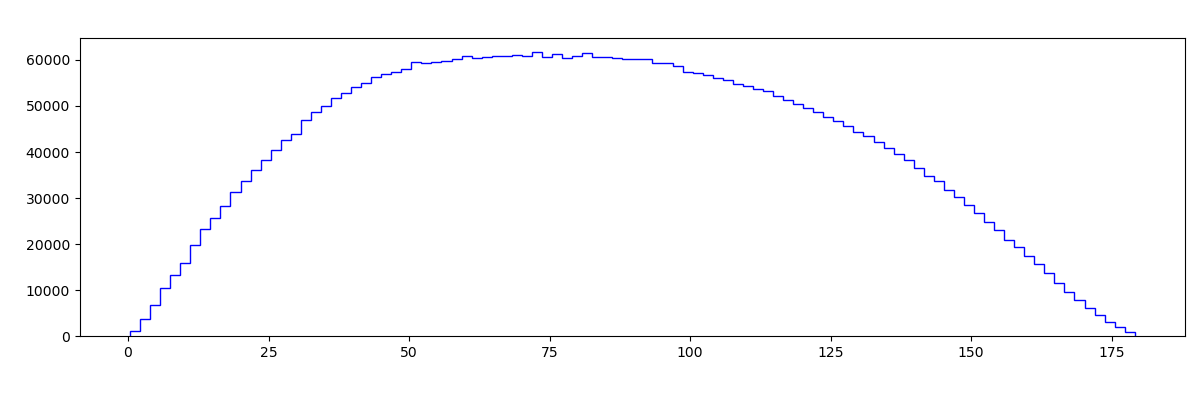

In [13]:
plt.clf()
#plt.hist2d(delta_loc.mag[filt_0], beta[filt_0], bins=(30, 300), cmap='viridis', cmax=10000)
plt.hist(beta[filt_0], bins=100, histtype='step', label='Beta', color='blue')

plt.show()

### Compute $\sigma_D$

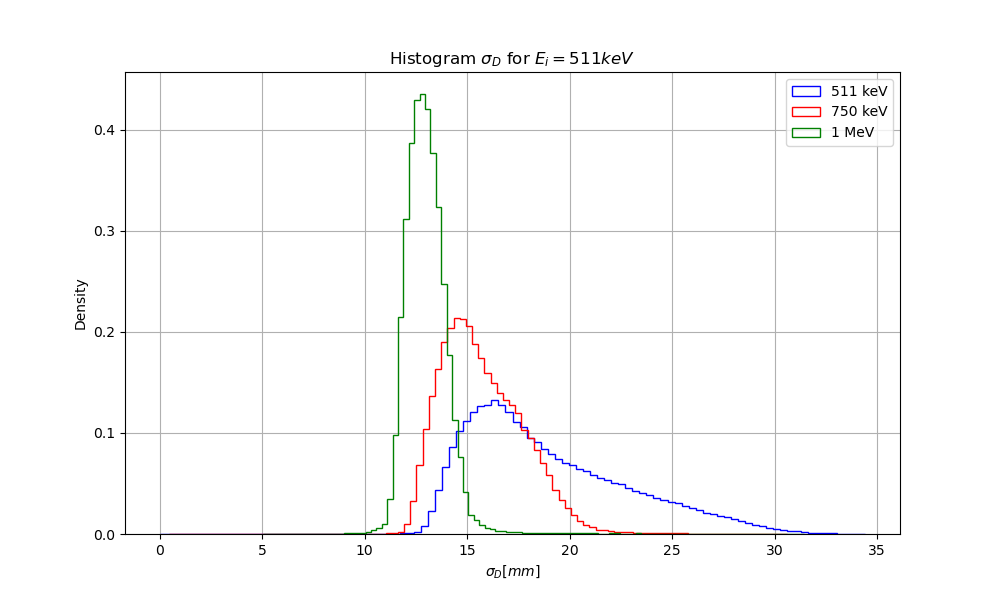

In [15]:
from scipy.stats import norm

sigma_D_val = sigma_D(r1_loc[filt],r2_loc[filt],delta_loc[filt],edep[filt],
                        theta[filt],beta[filt],
                        sigma_par,sigma_perp,sigma_E)
sigma_D_val750 = sigma_D(r1_loc750[filt750],r2_loc750[filt750],delta_loc750[filt750],edep_750[filt750],
                        theta750[filt750],beta750[filt750],
                        sigma_par,sigma_perp,sigma_E)
sigma_D_val1M = sigma_D(r1_loc1M[filt1M],r2_loc1M[filt1M],delta_loc1M[filt1M],edep_1M[filt1M],
                        theta1M[filt1M],beta1M[filt1M],
                        sigma_par,sigma_perp,sigma_E)

# Set your desired fit range
# a, b = 10, 100
# range_mask = (sigma_D_val >= a) & (sigma_D_val <= b)
# fit_data = sigma_D_val[range_mask]


plt.clf()
# il _ dice di perdere tutto il resto :D
plt.figure(figsize=(10, 6))

# Plot histograms with different colors and styles
counts, bins, _ = plt.hist(sigma_D_val, density=True, bins=100, histtype='step', 
                          label='511 keV', color='blue')
counts, bins, _ = plt.hist(sigma_D_val750, density=True, bins=100, histtype='step',
                          label='750 keV', color='red')
counts, bins, _ = plt.hist(sigma_D_val1M, density=True, bins=100, histtype='step',
                          label='1 MeV', color='green')

plt.xlabel(r'$\sigma_D[mm]$')
plt.grid(True)
plt.ylabel('Density')
plt.legend()
plt.title('Histogram $\sigma_D$ for $E_i = 511keV$')
plt.show()


/tmp/ipykernel_2945/3643100431.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


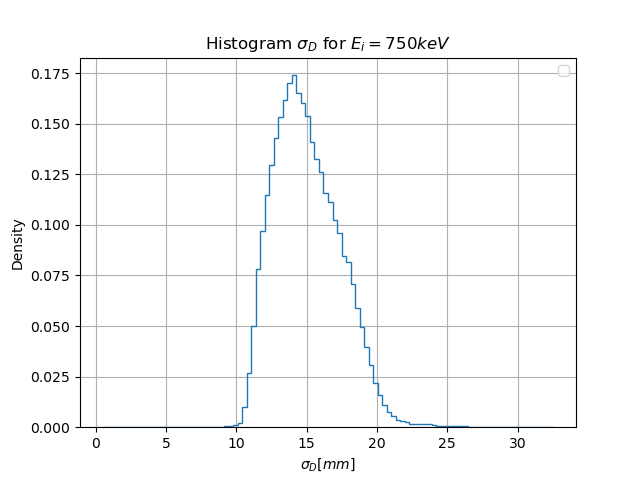

In [38]:
from scipy.stats import norm

sigma_D_val_750 = sigma_D(r1_loc750[filt750],r2_loc750[filt750],delta_loc750[filt750],edep_750[filt750],
                        theta750[filt750],beta750[filt750],
                        sigma_par,sigma_perp,sigma_E)

# Set your desired fit range
# a, b = 10, 100
# range_mask = (sigma_D_val >= a) & (sigma_D_val <= b)
# fit_data = sigma_D_val[range_mask]


plt.clf()
# il _ dice di perdere tutto il resto :D
counts, bins, _ = plt.hist(sigma_D_val_750,density=True, bins=100, histtype='step')

plt.xlabel(r'$\sigma_D[mm]$')
plt.grid(True)
plt.ylabel('Density')
plt.legend()
plt.title('Histogram $\sigma_D$ for $E_i = 750keV$')
plt.show()


/tmp/ipykernel_2945/1602325612.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


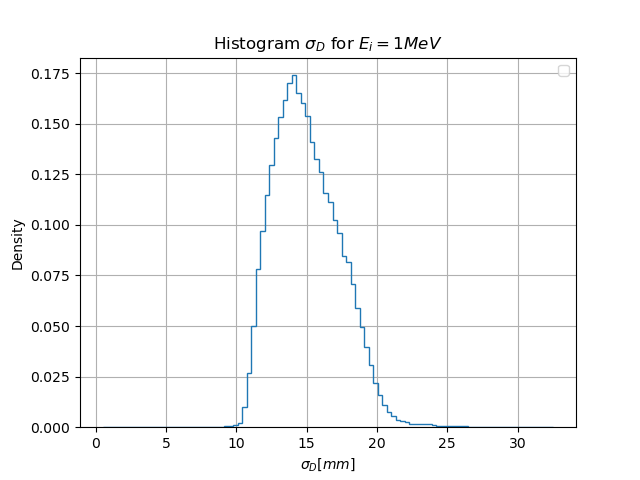

In [ ]:
from scipy.stats import norm

sigma_D_val_1M = sigma_D(r1_loc1M[filt1M],r2_loc1M[filt1M],delta_loc1M[filt1M],edep_1M[filt1M],
                        theta1M[filt1M],beta1M[filt1M],
                        sigma_par,sigma_perp,sigma_E)

# Set your desired fit range
# a, b = 10, 100
# range_mask = (sigma_D_val >= a) & (sigma_D_val <= b)
# fit_data = sigma_D_val[range_mask]


plt.clf()
# il _ dice di perdere tutto il resto :D
counts, bins, _ = plt.hist(sigma_D_val_750,density=True, bins=100, histtype='step')

plt.xlabel(r'$\sigma_D[mm]$')
plt.grid(True)
plt.ylabel('Density')
plt.legend()
plt.title('Histogram $\sigma_D$ for $E_i = 1MeV$')
plt.show()

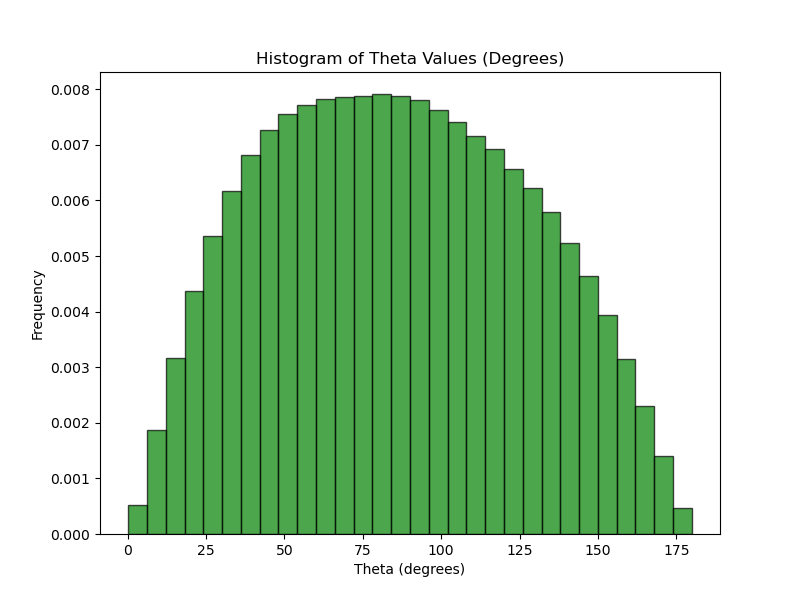

In [42]:
# Extract phi and theta values from r1
phi_values = np.degrees(delta_loc.phi)  # Convert phi from radians to degrees
theta_values = np.degrees(delta_loc[delta_loc.mag>0].theta)  # Convert theta from radians to degrees
# scaDtt_angle = np.degrees(scatt_angle[delta_loc.mag>0])  # Convert theta from radians to degrees

# Plot histogram for phi values
# plt.figure(figsize=(8, 6))
# plt.hist(phi_values, bins=30, color='blue', alpha=0.7, edgecolor='black')
# plt.title("Histogram of Phi Values (Degrees)")
# plt.xlabel("Phi (degrees)")
# plt.ylabel("Frequency")

# plt.show()

# Plot histogram for theta values
plt.figure(figsize=(8, 6))
plt.hist(theta_values, bins=30, color='green', alpha=0.7, edgecolor='black',density=True)
# plt.hist(scatt_angle, bins=30, color='red', alpha=0.7, edgecolor='black',density=True)
plt.title("Histogram of Theta Values (Degrees)")
plt.xlabel("Theta (degrees)")
plt.ylabel("Frequency")
plt.show()


# plt.figure(figsize=(8, 6))
# # plt.hist(scatt_angle, bins=30, color='blue', alpha=0.7, edgecolor='black')
# plt.title("Histogram of Phi Values (Degrees)")
# plt.xlabel("Phi (degrees)")
# plt.ylabel("Frequency")

# plt.show()



## Klein-Nishina Plots

Normalized Area: 1.000


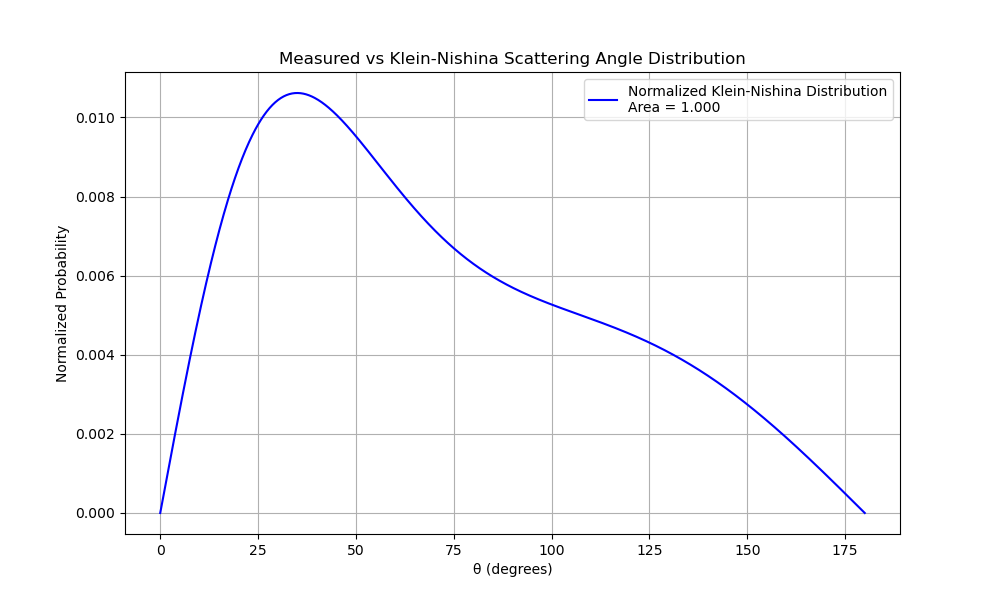

In [47]:

from scipy.integrate import simpson  # For numerical integration
delta_cut= 12

# Constants
electron_mass_keV = 511  # Electron rest mass energy in keV
incident_energy = 511  # Incident photon energy in keV
r_e = 2.817e-15  # Classical electron radius in meters


theta_degrees = np.linspace(0, 180, 1000)  # Angles from 0 to 180 degrees
klein_nishina_distribution = klein_nishina(theta_degrees, incident_energy)*2*np.pi*np.sin(np.radians(theta_degrees))

# Normalize the Klein-Nishina distribution
integral = simpson(klein_nishina_distribution, theta_degrees)  
klein_nishina_distribution_normalized = klein_nishina_distribution / integral  

# Verify normalization
normalized_integral = simpson(klein_nishina_distribution_normalized, theta_degrees)
print(f"Normalized Area: {normalized_integral:.3f}")  # Should be close to 1

# Normalize the histogram
tot_compt_events = meta['totFirstCompt']
fract = len(r1[filt_0])/meta['totFirstCompt']

# Plot the normalized Klein-Nishina distribution
plt.figure(figsize=(10, 6))
plt.plot(
    theta_degrees,
    klein_nishina_distribution_normalized,
    color='blue',
    label=f"Normalized Klein-Nishina Distribution\nArea = {normalized_integral:.3f}"
)

# Overlay the normalized histogram for theta values
# plt.hist(theta_values, bins=50, density=False, alpha=0.5, label='Measured Histogram', edgecolor='black')
# plt.clf()


# Add labels, title, and legend
plt.title("Measured vs Klein-Nishina Scattering Angle Distribution")
plt.xlabel("θ (degrees)")
plt.ylabel("Normalized Probability")
plt.legend()
plt.grid(True)
plt.show()